# Algorithm 1

In [24]:
# Dependencies
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Settings
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 8)

# Read and filter data
df_spx = pd.read_csv('/content/snp500_history.csv').drop(columns=['Dividends', 'Stock Splits'])
df_spx['Date'] = pd.to_datetime(df_spx['Date']).apply(lambda x: x.strftime('%Y-%m-%d'))
df_spx.set_index('Date', inplace=True)
df_spx = df_spx['2008-09' : '2018-09']
df_spx['ret'] = abs(df_spx['Close'] - df_spx['Close'].shift(1)) / df_spx['Close'].shift(1)#for RMSE relative to naive pred
df_spx['ret'][0] = 0
df_spx['ret_naive'] = df_spx['ret'].shift(1)
df_spx['ret_naive'][0] = 0
df_spx


,Open,High,Low,Close,Volume,ret,ret_naive
Date,,,,,,,
2008-09-02,1287.829956,1303.040039,1272.199951,1277.579956,4783560000,0.000000,0.000000
2008-09-03,1276.609985,1280.599976,1265.589966,1274.979980,5056980000,0.002035,0.000000
2008-09-04,1271.800049,1271.800049,1232.829956,1236.829956,5212500000,0.029922,0.002035
2008-09-05,1233.209961,1244.939941,1217.229980,1242.310059,5017080000,0.004431,0.029922
...,...,...,...,...,...,...,...
2018-08-28,2901.449951,2903.770020,2893.500000,2897.520020,2687770000,0.000269,0.007670
2018-08-29,2900.620117,2916.500000,2898.399902,2914.040039,2805520000,0.005701,0.000269
2018-08-30,2908.939941,2912.459961,2895.219971,2901.129883,2810450000,0.004430,0.005701
2018-08-31,2898.370117,2906.320068,2891.729980,2901.520020,2887220000,0.000134,0.004430


In [25]:
from scipy.linalg import LinAlgError
from sklearn.metrics import mean_squared_error

np.random.seed(0)

def Alg_1(df_spx, n, lambda_gg=-1, gamma_gg=-1, Nmod=30, Nhyp=11): # n = [1, 12]
    df = df_spx.copy()

    predicti, gamma_list, lambda_list = [], [], []

    # Step 1
    gamma = [0.01 + np.random.uniform(0.5 ** (1/n), 1) for i in range(Nmod)]
    lambda_i = [0] + [np.random.uniform(0, 1) for i in range(Nmod)]
    # print(f"Lambda = {lambda_i}")
    eta = [0.89 + 0.01 * j for j in range(Nhyp)] # ню
    # Step 2
    CSE = np.zeros(Nhyp)
    CSE_i = np.zeros((Nmod, Nhyp))
    # Step 3
    g = [np.zeros(n) for _ in range(Nmod)]
    H_inv = [np.zeros((n, n)) for _ in range(Nmod)]
    H = [np.zeros((n, n)) for _ in range(Nmod)]

    x_t = np.zeros(n)
    y_pred = np.zeros(Nmod)

    def prepare_feature_vector(df, t, x_t):
        previous_date = df.index[t - 1]
        x_t = np.delete(x_t, 0)
        x_t = np.append(x_t, df['Close'].loc[previous_date])
        return np.array(x_t)

    def observe_target(df, t):
        current_date = df.index[t]
        previous_date = df.index[t - 1]
        y_t = abs((df.loc[current_date, 'Close'] - df.loc[previous_date, 'Close']) / df.loc[previous_date, 'Close'])
        # return current_date
        # print(y_t)
        return y_t

    for t in range(1, len(df)):
        ## Step 5
        x_t = prepare_feature_vector(df, t, x_t)


        ## Step 6 - find optimal CSE forgetting rate (eta)
        j_star = np.argmin(CSE)
        ## Step 7 - find the optimal model using the optimal CSE
        i_star = np.argmin(CSE_i[:, j_star])

        ## Step 8 - make prediction using optimal model
        y_pred[i_star] = x_t.T.dot(H_inv[i_star]).dot(g[i_star]) # r_t+1 - r_t = predict
        ## Step 9 - observe the real target
        y_t = observe_target(df, t)
        predicti.append(y_pred[i_star])

        # Step 10 - for each parameter value
        for j in range(Nhyp):
            # Step 11 - find the optimal model given the parameter
            i_star_j = np.argmin(CSE_i[:, j])
            #Step 12 - make prediction with the optimal model given the parameter
            CSE[j] += (y_pred[i_star_j] - y_t)**2

        for i in range(Nmod):
            ### Step 15 - for each model make a prediction
            y_pred[i] = x_t.T.dot(H_inv[i]).dot(g[i])

            ### Step 16 - for each parameter value
            for j in range(Nhyp):
                ### Update the model CSE given the parameter given the model
                CSE_i[i,j] = eta[j] * CSE_i[i,j] + (y_pred[i] - y_t)**2

            ### Step 17 - compute the new gamma
            if gamma_gg == -1:
                g[i] = g[i] * gamma[i] + x_t * (y_t)
            else:
                g[i] = g[i] * gamma_gg + x_t * (y_t)

            ### O(n**3)
            # Lemma 2 instead of Steps 18 - 20
            if gamma_gg == -1 and lambda_gg == -1:
                H[i] = gamma[i] * H[i] + np.outer(x_t, x_t) + lambda_i[i] * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])
                # H_inv[i] = np.linalg.pinv(H[i])
            elif lambda_gg == -1:
                H[i] = gamma_gg * H[i] + np.outer(x_t, x_t) + lambda_i[i] * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])
            elif gamma_gg == -1:
                H[i] = gamma[i] * H[i] + np.outer(x_t, x_t) + lambda_gg * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])
            else:
                H[i] = gamma_gg * H[i] + np.outer(x_t, x_t) + lambda_gg * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])

            # ### Step 18
            # H_inv[i] = H_inv[i] / gamma[i] + np.outer(x_t, x_t) # pd.DataFrame(x_t).dot(pd.DataFrame(x_t).T).to_numpy() == np.outer(x_t, x_t)
            # ### Step 19
            # H_inv[i] = Update(H_inv[i], x_t, gamma[i])
            # ### Step 20
            # H_inv[i] = Update(H_inv[i], (lambda_i[i] ** 0.5) * x_t, gamma[i])

        # relative_mse_algorithm1 = mse_ret / mse_naive
        if gamma_gg == -1:
            gamma_list.append(gamma[np.argmin(CSE)])
        else:
            gamma_list.append(gamma_gg)
        if lambda_gg == -1:
            lambda_list.append(lambda_i[np.argmin(CSE)])
        else:
            lambda_list.append(lambda_gg)

        # print("fuck - ", j, np.argmin(CSE))
        # print("__________________________")
    # optimal_model = np.argmin(CSE)
    df['gamma'] = [0] + gamma_list
    df['lambda'] = [0] + lambda_list
    # df['relative_mse'] = relative_mse_algorithm1

    ## Calculating predictions and naive_observations
    df['pred_alg1'] = [0] + predicti
    return df


def rel_mse_func(df):
    mse_ret = mean_squared_error(df['ret'], df['pred_alg1'])  # Calculate MSE for 'ret' and 'pred'
    mse_naive = mean_squared_error(df['ret'], df['ret_naive'])  # Calculate MSE for 'ret' and 'ret_naive'
    # Calculate the relative MSE
    return mse_ret / mse_naive

# Experiment 1
___

comparing the propose regularisation with L2 regularisation

### tests

In [26]:
from scipy.linalg import LinAlgError
from sklearn.metrics import mean_squared_error

np.random.seed(0)

def Alg_1_exp1(df_spx, n, lambda_gg=-1, gamma_gg=-1, Nmod=30, Nhyp=11): # n = [1, 12]
    df = df_spx.copy()

    predicti, gamma_list, lambda_list = [], [], []

    # Step 1
    gamma = [0.01 + np.random.uniform(0.5 ** (1/n), 1) for i in range(Nmod)]
    lambda_i = [0] + [np.random.uniform(0, 1) for i in range(Nmod)]
    # print(f"Lambda = {lambda_i}")
    eta = [0.89 + 0.01 * j for j in range(Nhyp)] # ню
    # Step 2
    CSE = np.zeros(Nhyp)
    CSE_i = np.zeros((Nmod, Nhyp))
    # Step 3
    g = [np.zeros(n) for _ in range(Nmod)]
    H_inv = [np.zeros((n, n)) for _ in range(Nmod)]
    H = [np.zeros((n, n)) for _ in range(Nmod)]

    x_t = np.zeros(n)
    y_pred = np.zeros(Nmod)

    def prepare_feature_vector(df, t, x_t):
        previous_date = df.index[t - 1]
        x_t = np.delete(x_t, 0)
        x_t = np.append(x_t, df['Close'].loc[previous_date])
        return np.array(x_t)

    def observe_target(df, t):
        current_date = df.index[t]
        # previous_date = df.index[t - 1]
        # y_t = abs((df.loc[current_date, 'Close'] - df.loc[previous_date, 'Close']) / df.loc[previous_date, 'Close'])
        # # return current_date
        # print(y_t)
        return current_date
        # return y_t

    # def observe_target(df, t):
    #     current_date = df.index[t]
    #     previous_date = df.index[t - 1]
    #     y_t = abs((df.loc[current_date, 'Close'] - df.loc[previous_date, 'Close']) / df.loc[previous_date, 'Close'])
    #     # return current_date
    #     return y_t

    def Update(H, x_flat, gamma):
        x = np.expand_dims(x_flat, 1)
        H_next_inv = gamma**-1 * H - ((gamma**-2 * H @ x @ x.transpose() @ H) /
                                      (1 + gamma**-1 * x.transpose() @ H @ x))
        return H_next_inv

    for t in range(1, len(df)):
        ## Step 5
        x_t = prepare_feature_vector(df, t, x_t)

        ## Step 6 - find optimal CSE forgetting rate (eta)
        j_star = np.argmin(CSE)
        ## Step 7 - find the optimal model using the optimal CSE
        i_star = np.argmin(CSE_i[:, j_star])

        ## Step 8 - make prediction using optimal model
        y_pred[i_star] = x_t.T.dot(H_inv[i_star]).dot(g[i_star]) # r_t+1 - r_t = predict
        ## Step 9 - observe the real target
        y_t = observe_target(df, t)
        predicti.append(y_pred[i_star])

        # Step 10 - for each parameter value
        for j in range(Nhyp):
            # Step 11 - find the optimal hyperforgetting rate given the parameter
            i_star_j = np.argmin(CSE_i[:, j])
            #Step 12 - make prediction with the optimal model given the parameter
            CSE[j] += (y_pred[i_star_j] - y_t)**2

        for i in range(Nmod):
            ### Step 15 - for each model make a prediction
            y_pred[i] = x_t.T.dot(H_inv[i]).dot(g[i])

            ### Step 16 - for each parameter value
            for j in range(Nhyp):
                ### Update the model CSE given the parameter given the model
                CSE_i[i,j] = eta[j] * CSE_i[i,j] + (y_pred[i] - y_t)**2

            ### Step 17 - compute the new gamma
            if gamma_gg == -1:
                g[i] = g[i] * gamma[i] + x_t * (y_t)
            else:
                g[i] = g[i] * gamma_gg + x_t * (y_t)

            ### O(n**3)
            # Lemma 2 instead of Steps 18 - 20
            if gamma_gg == -1 and lambda_gg == -1:
                H[i] = gamma[i] * H[i] + np.outer(x_t, x_t) + lambda_i[i] * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])
                # H_inv[i] = np.linalg.pinv(H[i])
            elif lambda_gg == -1:
                H[i] = gamma_gg * H[i] + np.outer(x_t, x_t) + lambda_i[i] * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])
            elif gamma_gg == -1:
                H[i] = gamma[i] * H[i] + np.outer(x_t, x_t) + lambda_gg * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])
            else:
                H[i] = gamma_gg * H[i] + np.outer(x_t, x_t) + lambda_gg * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])

            # ### Step 18
            # H_inv[i] = H_inv[i] / gamma[i] + np.outer(x_t, x_t) # pd.DataFrame(x_t).dot(pd.DataFrame(x_t).T).to_numpy() == np.outer(x_t, x_t)
            # ### Step 19
            # H_inv[i] = Update(H_inv[i], x_t, gamma[i])
            # ### Step 20
            # H_inv[i] = Update(H_inv[i], (lambda_i[i] ** 0.5) * x_t, gamma[i])

        # relative_mse_algorithm1 = mse_ret / mse_naive
        if gamma_gg == -1:
            gamma_list.append(gamma[np.argmin(CSE)])
        else:
            gamma_list.append(gamma_gg)
        if lambda_gg == -1:
            lambda_list.append(lambda_i[np.argmin(CSE)])
        else:
            lambda_list.append(lambda_gg)

        # print("fuck - ", j, np.argmin(CSE))
        # print("__________________________")
    # optimal_model = np.argmin(CSE)
    df['gamma'] = [0] + gamma_list
    df['lambda'] = [0] + lambda_list
    # df['relative_mse'] = relative_mse_algorithm1

    ## Calculating predictions and naive_observations
    df['pred_alg1'] = [0] + predicti

    # mse_ret = mean_squared_error(df['ret'], df['pred_alg1'])  # Calculate MSE for 'ret' and 'pred'
    # mse_naive = mean_squared_error(df['ret'], df['ret_naive'])  # Calculate MSE for 'ret' and 'ret_naive'
    # # Calculate the relative MSE
    # relative_mse_algorithm1 = mse_ret / mse_naive

    # df = df.drop(columns=['gamma', 'lambda'])

    # print(f"Relative Mean Squared Error for '{n}':", relative_mse_algorithm1)
    return df

### Further

In [27]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import math
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from scipy.optimize import minimize

# Load Data
url = 'sunspots.csv'
df = pd.read_csv(url)
display(df)
df['Close'] = df['x']
df = df.drop(columns='x', axis=1);

,x
0,58.0
1,62.6
2,70.0
3,55.7
...,...
2816,50.3
2817,55.8
2818,33.3
2819,33.4


In [28]:
# Class for an autoregressive model with L2 regularization

class AutoRegressiveModelWithL2Regularization:
    """
    This class implements an autoregressive model with L2 regularization.
    """
    def __init__(self, order=1, regularization_param=1.0):
        self.order = order                                # Order of the AR model
        self.regularization_param = regularization_param  # L2 regularization parameter
        self.coefficients = None                          # Placeholder for AR coefficients, set after model fitting.

    def fit(self, data):
        """
        Fits the model to the provided data.

        Parameters:
        - data (np.array): Time series data.
        """
        n = len(data)
        # Prepare the input matrix X and target vector y for regression based on the AR order
        X = np.zeros((n - self.order, self.order))
        y = data[self.order:]

        for i in range(self.order, n):
            X[i - self.order, :] = data[i - self.order:i][::-1]

        # Define the objective function for optimization, which includes L2 regularization
        def objective_function(params, X, y, regularization_param):
            errors = y - np.dot(X, params)  # Errors between actual and predicted values
            return np.dot(errors, errors) + regularization_param * np.dot(params, params) # Sum of squared errors with regularization

        initial_guess = np.zeros(self.order)
        result = minimize(objective_function, initial_guess, args=(X, y, self.regularization_param))
        # Store the optimized coefficients
        self.coefficients = result.x

    def predict(self, data):
        n = len(data)
        predictions = np.zeros(n)

        # Generate predictions using the AR model coefficients
        for i in range(self.order, n):
            predictions[i] = np.dot(data[i - self.order:i][::-1], self.coefficients)

        return predictions[self.order:]

# Create an instance of the AR model with order 4 and regularization parameter 1.0
model = AutoRegressiveModelWithL2Regularization(order=4, regularization_param=1.0)
model.fit(df.Close[:1000])
# Predict the values for the data after the 1000th observation
predictions = model.predict(df.Close[1000:])
# Print the model coefficients and RMSE for the predictions
print("Model Coefficients:", model.coefficients)
rmse = np.sqrt(mean_squared_error(df.Close[1000+4:], predictions))
print("Root Mean Squared Error (RMSE):", rmse)

Model Coefficients: [0.54147374 0.14138958 0.12994476 0.16902811]
Root Mean Squared Error (RMSE): 16.437173750402916


In [29]:
# For different regularization parameters predict using algorithm proposed by OSU and L2

# regularization_values = [0.1, 0.5, 1.0]
regularization_values = np.arange(0, 100, 10)
rmse_values = []      # List to store RMSE for the OSU algorithm predictions
rmse_values_auto = [] # List to store RMSE for the AutoRegressiveModel predictions

for regularization_param in regularization_values:
    # Predict using algorithm proposed by OSU
    predictions = Alg_1_exp1(df[1000:], 1, regularization_param, 0.99)

    # Calculate RMSE for the OSU algorithm predictions
    rmse = np.sqrt(mean_squared_error(df.Close[1000:], predictions.pred_alg1))
    rmse_values.append(rmse)

    # Predict using AutoRegressiveModel
    ord = 3 # The order of model set to 3
    model = AutoRegressiveModelWithL2Regularization(order=ord, regularization_param=regularization_param)
    model.fit(df.Close[:1000])
    predictions_auto = model.predict(df.Close[1000:])

    # Calculate RMSE for the AutoRegressiveModel predictions
    rmse_auto = np.sqrt(mean_squared_error(df.Close[1000+ord:], predictions_auto))
    rmse_values_auto.append(rmse_auto)

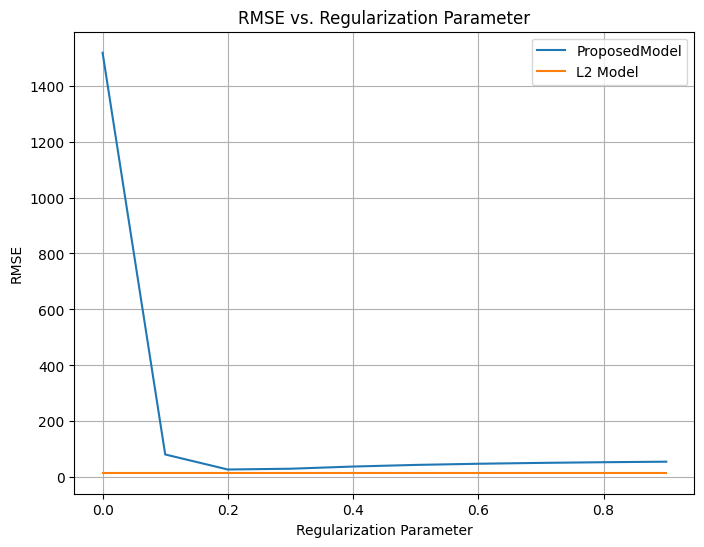

In [30]:
# Plot the predictions
plt.figure(figsize=(8, 6))
plt.plot(regularization_values/100, rmse_values, label='ProposedModel')
plt.plot(regularization_values/100, rmse_values_auto, label='L2 Model')
plt.title("RMSE vs. Regularization Parameter")
plt.xlabel("Regularization Parameter")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()

0.2 proposed == L2 model performance

# Experiment 2
---
---

Adaptive hyperparameters vs static ones (gamma and lambda)

In [31]:
# Function for generating time seriece using AR model
def generate_time_series(steps=2000, change_point=1000):
    """
    Generates a time series using an AR model, with a change in parameters at a specified change point.

    Parameters:
    - steps (int): The total number of time steps to be generated.
    - change_point (int): The time step at which the AR model parameters change.

    Returns:
    - x (np.array): The generated time series.
    """
    x = np.zeros(steps)

    # Generate white noise (epsilon) from a normal distribution with mean 0 and standard deviation 1
    epsilon = np.random.normal(0, 1, steps)

    for t in range(steps):
        # Before the change point, set mu to -10 and a to 0.3
        if t < change_point:
            mu, a = -10, 0.3
        # After the change point, set mu to 10 and a to -0.3
        else:
            mu, a = 10, -0.3
        # AR(1) model equation: x[t] = mu + a * x[t-1] + epsilon[t]
        # For the first time step (t=0), x[t-1] is not defined, so we use 0 as its value.
        x[t] = mu + a * (x[t-1] if t > 0 else 0) + epsilon[t]
    return x

data = generate_time_series() #generate time seriece
df_spx = pd.DataFrame(data, columns=['Close'])
df_spx.index = pd.date_range("20220101", periods=len(df_spx))

# Prepearing time seriece for forecasting
df_spx['ret'] = abs(df_spx['Close'] - df_spx['Close'].shift(1)) / df_spx['Close'].shift(1)
df_spx['ret'] = df_spx['ret'].replace(np.inf, 0)
df_spx['ret'][0] = 0
df_spx['ret_naive'] = df_spx['ret'].shift(1)
df_spx['ret_naive'][0] = 0

<Axes: >

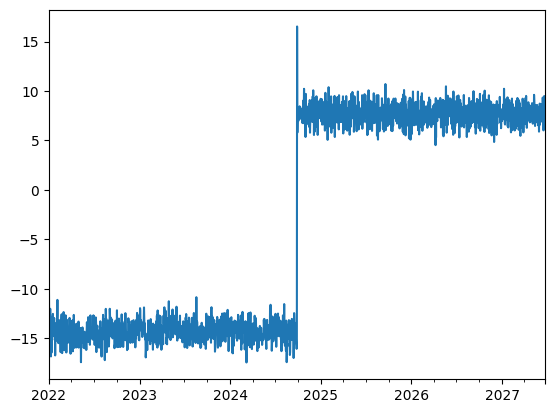

In [32]:
df_spx.Close.plot()

In [33]:
def rel_mse_func(df):
    mse_ret = mean_squared_error(df['ret'], df['pred_alg1'])**0.5  # Calculate MSE for 'ret' and 'pred'
    mse_naive = mean_squared_error(df['ret'], df['ret_naive'])**0.5  # Calculate MSE for 'ret' and 'ret_naive'
    # Calculate the relative MSE
    return (mse_ret / mse_naive)

In [34]:
df = Alg_1(df_spx, 12, -1, -1)          # using Algorithm 1 with auto lamda and gamma to compare it with constant ones
rel_mse_line = [rel_mse_func(df)] * 100 # creating data to rmse line

In [35]:
# creating data to rmse line
lam_list_for_rel_mse = []
lam_for_rel_mse = 0
for i in range(100):
  lam_for_rel_mse += 0.001
  lam_list_for_rel_mse.append(lam_for_rel_mse)

In [36]:
#df = Alg_1(df_spx, 12, -1, -1)

# Calculating RMSE for Lambdas (from 0 to 0.1 with step 0.005) and for gammas 1, 0.99, 0.9

# 1 year before changepoint

# For gamma=1
lam_list = []    #list for lamdas seriece
rmse_list_1 = [] #list of rmse for different lambdas
lam = 0
for _ in range (21):    #Algorithm 1 for 21 steps of lambda change
  lam_list.append(lam)
  df1 = Alg_1(df_spx.loc["2023-09-26":"2024-09-26"], 12, lam, 1) #1 year period
  rmse_local = rel_mse_func(df1) #calculating RMSE
  rmse_list_1.append(rmse_local)
  lam += 0.005  #increasing lamda

# For gamma=0.99
lam_list = []
rmse_list_099_1 = []
lam = 0
for _ in range (21):
  lam_list.append(lam)
  df1 = Alg_1(df_spx.loc["2023-09-26":"2024-09-26"], 12, lam, 0.99)
  rmse_local = rel_mse_func(df1)
  rmse_list_099_1.append(rmse_local)
  lam += 0.005

# For gamma=0.9
lam_list = []
rmse_list_09_1 = []
lam = 0
for _ in range (21):
  lam_list.append(lam)
  df1 = Alg_1(df_spx.loc["2023-09-26":"2024-09-26"], 12, lam, 0.9)
  rmse_local = rel_mse_func(df1)
  rmse_list_09_1.append(rmse_local)
  lam += 0.005

#  1 year after changepoint

# For gamma=1
lam_list = []
rmse_list_2 = []
lam = 0
for _ in range (21):
  lam_list.append(lam)
  df1 = Alg_1(df_spx.loc["2024-09-26":"2025-09-26"], 12, lam, 1)
  rmse_local = rel_mse_func(df1)
  rmse_list_2.append(rmse_local)
  lam += 0.005

# For gamma=0.99
lam_list = []
rmse_list_099_2 = []
lam = 0
for _ in range (21):
  lam_list.append(lam)
  df1 = Alg_1(df_spx.loc["2024-09-26":"2025-09-26"], 12, lam, 0.99)
  rmse_local = rel_mse_func(df1)
  rmse_list_099_2.append(rmse_local)
  lam += 0.005

# For gamma=0.9
lam_list = []
rmse_list_09_2 = []
lam = 0
for _ in range (21):
  lam_list.append(lam)
  df1 = Alg_1(df_spx.loc["2024-09-26":"2025-09-26"], 12, lam, 0.9)
  rmse_local = rel_mse_func(df1)
  rmse_list_09_2.append(rmse_local)
  lam += 0.005

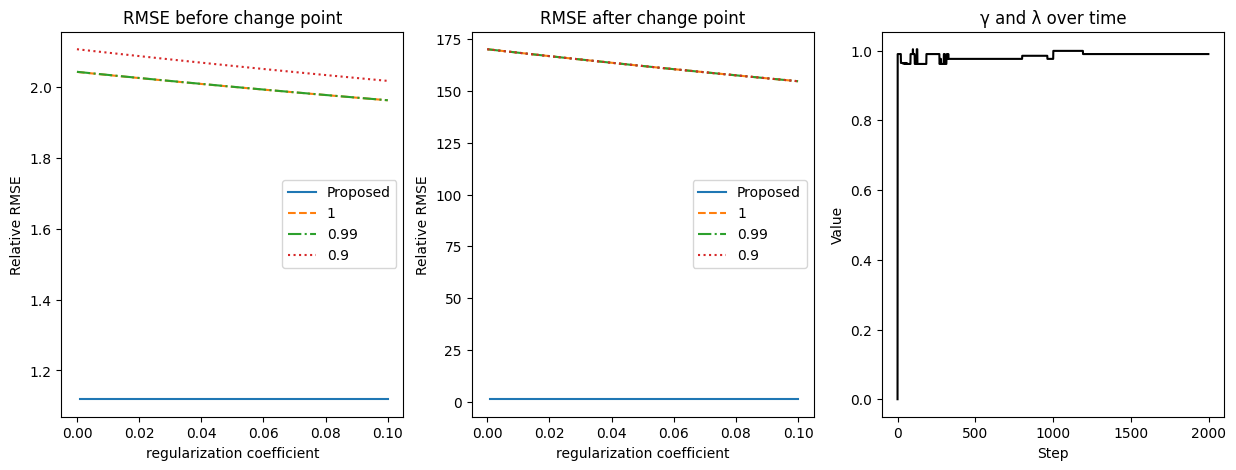

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_custom_graphs(df):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Figure 2a
    axs[0].plot(lam_list_for_rel_mse, rel_mse_line, label="Proposed", linestyle='-')
    axs[0].plot(lam_list, rmse_list_1, label="1", linestyle='--')
    axs[0].plot(lam_list, rmse_list_099_1, label="0.99", linestyle='-.' )
    axs[0].plot(lam_list, rmse_list_09_1, label="0.9", linestyle=':')
    axs[0].set_title("RMSE before change point")
    axs[0].set_xlabel("regularization coefficient")
    axs[0].set_ylabel("Relative RMSE")
    axs[0].legend()
    axs[0]

    # Figure 2b
    axs[1].plot(lam_list_for_rel_mse, rel_mse_line, label="Proposed", linestyle='-')
    axs[1].plot(lam_list, rmse_list_2, label="1", linestyle='--')
    axs[1].plot(lam_list, rmse_list_099_2, label="0.99", linestyle='-.' )
    axs[1].plot(lam_list, rmse_list_09_2, label="0.9", linestyle=':')
    axs[1].set_title("RMSE after change point")
    axs[1].set_xlabel("regularization coefficient")
    axs[1].set_ylabel("Relative RMSE")
    axs[1].legend()
    axs[1]

    # Figure 2c
    df.reset_index(drop=True, inplace=True)
    axs[2].plot(df.index, df['gamma'], label="gamma", color='black')
    #axs[2].plot(df.index, df['lambda'], label="lambda", color='blue', linestyle='--')
    axs[2].set_title("γ and λ over time")
    axs[2].set_xlabel("Step")
    axs[2].set_ylabel("Value")
    axs[2].legend

plot_custom_graphs(df)

# Experiment 3
---
---
---

In [38]:
# Read and filter data
df_spx = pd.read_csv('/content/snp500_history.csv').drop(columns=['Dividends', 'Stock Splits'])
df_spx['Date'] = pd.to_datetime(df_spx['Date']).apply(lambda x: x.strftime('%Y-%m-%d'))
df_spx.set_index('Date', inplace=True)
df_spx = df_spx['2008-09' : '2018-09']
df_spx['ret'] = abs(df_spx['Close'] - df_spx['Close'].shift(1)) / df_spx['Close'].shift(1)
df_spx['ret'][0] = 0
df_spx['ret_naive'] = df_spx['ret'].shift(1)
df_spx['ret_naive'][0] = 0
df_spx

,Open,High,Low,Close,Volume,ret,ret_naive
Date,,,,,,,
2008-09-02,1287.829956,1303.040039,1272.199951,1277.579956,4783560000,0.000000,0.000000
2008-09-03,1276.609985,1280.599976,1265.589966,1274.979980,5056980000,0.002035,0.000000
2008-09-04,1271.800049,1271.800049,1232.829956,1236.829956,5212500000,0.029922,0.002035
2008-09-05,1233.209961,1244.939941,1217.229980,1242.310059,5017080000,0.004431,0.029922
...,...,...,...,...,...,...,...
2018-08-28,2901.449951,2903.770020,2893.500000,2897.520020,2687770000,0.000269,0.007670
2018-08-29,2900.620117,2916.500000,2898.399902,2914.040039,2805520000,0.005701,0.000269
2018-08-30,2908.939941,2912.459961,2895.219971,2901.129883,2810450000,0.004430,0.005701
2018-08-31,2898.370117,2906.320068,2891.729980,2901.520020,2887220000,0.000134,0.004430


In [39]:
df_spx['ret'] = abs(df_spx['Close'] - df_spx['Close'].shift(1)) / df_spx['Close'].shift(1)
df_spx['ret'][0] = 0
df_spx['ret_naive'] = df_spx['ret'].shift(1)
df_spx['ret_naive'][0] = 0
display(df_spx)
df_TRAIN = df_spx[:1000]
df_TRAIN
!pip install tensorflow-addons

from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, RMSprop
# from tensorflow_addons.optimizers import COGradient


def prepare_data(timeseries_data, n_steps):
    X, y = [], []
    for i in range(len(timeseries_data)):
        end_ix = i + n_steps
        if end_ix > len(timeseries_data)-1:
            break
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def AR_model(df, n_steps, opt):
    # Determine train and test data
    df_TRAIN = df_spx[:1000]
    df_TEST = df_spx[1000:1500]
    print(df_TEST.shape)

    # Transform data
    data = df_TRAIN['ret'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    X_train, y_train = prepare_data(scaled_data, n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Mapping optimizers
    optimizers = {
        'sgd': SGD(),
        'almeida': Adadelta(),
        'hgd': Adagrad(),
        # 'cogradient': COGradient(),
        'adam': Adam(),
        'rmsprop': RMSprop(),
        'adagrad': Adagrad()
    }

    # Set up model with the specified optimizer
    model = Sequential()
    model.add(Dense(1, activation='relu', input_dim=n_steps))
    model.compile(optimizer=optimizers[opt.lower()], loss='mse')

    #Fit model
    model.fit(X_train, y_train, epochs=15, batch_size=1, verbose=2)

    # Predict with model
    data = df_TEST['ret'].values.reshape(-1, 1)  # assuming your time series data is in a column named 'your_column_name'
    data = scaler.transform(data)
    X, y = prepare_data(data, n_steps)
    y_pred = model.predict(X)
    y_pred = scaler.inverse_transform(y_pred)

    #Record results and count MSE
    df_TEST = df_TEST.iloc[n_steps:n_steps+len(y_pred)]
    df_TEST['adam_pred'] = y_pred
    mse_ret = mean_squared_error(df_TEST['ret'], df_TEST['adam_pred'])  # Calculate MSE for 'ret' and 'pred'
    mse_naive = mean_squared_error(df_TEST['ret'], df_TEST['ret_naive'])  # Calculate MSE for 'ret' and 'ret_naive'
    relative_mse = mse_ret / mse_naive

    print("Mean Squared Error:", mse_ret)
    print("Relative Mean Squared Error:", relative_mse)

    return relative_mse

,Open,High,Low,Close,Volume,ret,ret_naive
Date,,,,,,,
2008-09-02,1287.829956,1303.040039,1272.199951,1277.579956,4783560000,0.000000,0.000000
2008-09-03,1276.609985,1280.599976,1265.589966,1274.979980,5056980000,0.002035,0.000000
2008-09-04,1271.800049,1271.800049,1232.829956,1236.829956,5212500000,0.029922,0.002035
2008-09-05,1233.209961,1244.939941,1217.229980,1242.310059,5017080000,0.004431,0.029922
...,...,...,...,...,...,...,...
2018-08-28,2901.449951,2903.770020,2893.500000,2897.520020,2687770000,0.000269,0.007670
2018-08-29,2900.620117,2916.500000,2898.399902,2914.040039,2805520000,0.005701,0.000269
2018-08-30,2908.939941,2912.459961,2895.219971,2901.129883,2810450000,0.004430,0.005701
2018-08-31,2898.370117,2906.320068,2891.729980,2901.520020,2887220000,0.000134,0.004430


In [ ]:
import matplotlib.pyplot as plt
optimizers_relative_mse = {
    'sgd': [],
    'almeida': [],
    'hgd': [],
    # 'cogradient': [],
    'adam': [],
    'rmsprop': [],
    'adagrad': []
}

# Loop through each optimizer and n_steps
optimizers = ['sgd', 'almeida', 'hgd', 'adam', 'rmsprop', 'adagrad']
for opt in optimizers:
    print('------------------------------------------')
    print('current optmizer is', opt)
    n_list = [1] + list(range(2, 13, 2))
    for n in n_list:
        relative_mse = 0
        cyc = 5
        for k in range(cyc):
            relative_mse += AR_model(df_spx[1000:], n, opt)

        optimizers_relative_mse[opt].append(relative_mse/cyc)

# optimizers_relative_mse['Algorithm 1'] = means
# Plotting the results
# for opt, mse_list in optimizers_relative_mse.items():
#     plt.plot(n_list, mse_list, label=opt)

# plt.xlabel('n_steps')
# plt.ylabel('Relative MSE')
# plt.title('Relative MSE vs n_steps for Different Optimizers')
# plt.legend()
# plt.ylim(0, 1.4)  # Setting the y-axis limits
# plt.show()

------------------------------------------
current optmizer is sgd
(500, 7)
Epoch 1/15
999/999 - 2s - loss: 0.0203 - 2s/epoch - 2ms/step
Epoch 2/15
999/999 - 1s - loss: 0.0175 - 1s/epoch - 1ms/step
Epoch 3/15
999/999 - 1s - loss: 0.0155 - 1s/epoch - 1ms/step
Epoch 4/15
999/999 - 1s - loss: 0.0145 - 1s/epoch - 1ms/step
Epoch 5/15
999/999 - 2s - loss: 0.0137 - 2s/epoch - 2ms/step
Epoch 6/15
999/999 - 2s - loss: 0.0134 - 2s/epoch - 2ms/step
Epoch 7/15
999/999 - 2s - loss: 0.0132 - 2s/epoch - 2ms/step
Epoch 8/15
999/999 - 3s - loss: 0.0130 - 3s/epoch - 3ms/step
Epoch 9/15
999/999 - 2s - loss: 0.0130 - 2s/epoch - 2ms/step
Epoch 10/15
999/999 - 2s - loss: 0.0129 - 2s/epoch - 2ms/step
Epoch 11/15
999/999 - 2s - loss: 0.0129 - 2s/epoch - 2ms/step
Epoch 12/15
999/999 - 2s - loss: 0.0129 - 2s/epoch - 2ms/step
Epoch 13/15
999/999 - 3s - loss: 0.0129 - 3s/epoch - 3ms/step
Epoch 14/15
999/999 - 3s - loss: 0.0129 - 3s/epoch - 3ms/step
Epoch 15/15
999/999 - 3s - loss: 0.0128 - 3s/epoch - 3ms/step
16/

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already computed mse_list

def for_mean(n):
    mse_list = [[] for _ in range(n)]
    for j in range(n):
        print(f"№{j} ______________________________________________________")
        for i in range(2, 13, 2):
            df = Alg_1(df_spx[1000:1500], i)
            mse_list[j] += [rel_mse_func(df)]
        # mse_list[j] += [Alg_1(df_spx[1000:1500], i, 30, 11) for i in range(2, 13, 2)]

    for j in range(n):
        print(f"№{j} ______________________________________________________")
        df = Alg_1(df_spx[1000:1500], 1,)
        mse_list[j] = [rel_mse_func(df)] + mse_list[j]
        # mse_list[j] = [Alg_1(df_spx[:100], 1, 30, 11)] + mse_list[j]

    return mse_list

mse_list = for_mean(10)
mse_array = np.array(mse_list)
means = np.mean(mse_array, axis=0); means

In [ ]:
for opt, mse_list in optimizers_relative_mse.items():
    plt.plot(n_list, mse_list, label=opt)
plt.plot(n_list, means, label='Alg1')

plt.xlabel('n_steps')
plt.ylabel('Relative MSE')
plt.title('Relative MSE vs n_steps for Different Optimizers')
plt.legend()
plt.ylim(0, 1.4)  # Setting the y-axis limits
plt.show()

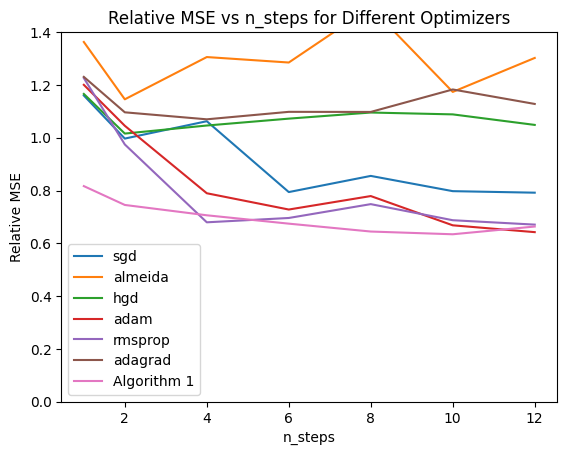

# Extra Outcome

## more tests

In [ ]:
from scipy.linalg import LinAlgError
from sklearn.metrics import mean_squared_error

np.random.seed(0)

def Alg_1_exp1(df_spx, n, lambda_gg=-1, gamma_gg=-1, Nmod=30, Nhyp=11): # n = [1, 12]
    df = df_spx.copy()

    predicti, gamma_list, lambda_list = [], [], []

    # Step 1
    gamma = [0.01 + np.random.uniform(0.5 ** (1/n), 1) for i in range(Nmod)]
    lambda_i = [0] + [np.random.uniform(0, 1) for i in range(Nmod)]
    # print(f"Lambda = {lambda_i}")
    eta = [0.89 + 0.01 * j for j in range(Nhyp)] # ню
    # Step 2
    CSE = np.zeros(Nhyp)
    CSE_i = np.zeros((Nmod, Nhyp))
    # Step 3
    g = [np.zeros(n) for _ in range(Nmod)]
    H_inv = [np.zeros((n, n)) for _ in range(Nmod)]
    H = [np.zeros((n, n)) for _ in range(Nmod)]

    x_t = np.zeros(n)
    y_pred = np.zeros(Nmod)

    def prepare_feature_vector(df, t, x_t):
        previous_date = df.index[t - 1]
        x_t = np.delete(x_t, 0)
        x_t = np.append(x_t, df.Close.loc[previous_date])
        return np.array(x_t)

    def observe_target(df, t):
        current_date = df.index[t]
        # previous_date = df.index[t - 1]
        # y_t = abs((df.loc[current_date, 'Close'] - df.loc[previous_date, 'Close']) / df.loc[previous_date, 'Close'])
        # # return current_date
        # print(y_t)
        return df.loc[current_date, 'Close']
        # return y_t

    # def observe_target(df, t):
    #     current_date = df.index[t]
    #     previous_date = df.index[t - 1]
    #     y_t = abs((df.loc[current_date, 'Close'] - df.loc[previous_date, 'Close']) / df.loc[previous_date, 'Close'])
    #     # return current_date
    #     return y_t

    def Update(H, x_flat, gamma):
        x = np.expand_dims(x_flat, 1)
        H_next_inv = gamma**-1 * H - ((gamma**-2 * H @ x @ x.transpose() @ H) /
                                      (1 + gamma**-1 * x.transpose() @ H @ x))
        return H_next_inv

    for t in range(1, len(df)):
        ## Step 5
        x_t = prepare_feature_vector(df, t, x_t)

        ## Step 6 - find optimal CSE forgetting rate (eta)
        j_star = np.argmin(CSE)
        ## Step 7 - find the optimal model using the optimal CSE
        i_star = np.argmin(CSE_i[:, j_star])

        ## Step 8 - make prediction using optimal model
        y_pred[i_star] = x_t.T.dot(H_inv[i_star]).dot(g[i_star]) # r_t+1 - r_t = predict
        ## Step 9 - observe the real target
        y_t = observe_target(df, t)
        predicti.append(y_pred[i_star])
        # Step 10 - for each parameter value
        for j in range(Nhyp):
            # Step 11 - find the optimal model given the parameter
            i_star_j = np.argmin(CSE_i[:, j])
            #Step 12 - make prediction with the optimal model given the parameter
            CSE[j] += (y_pred[i_star_j] - y_t)**2

        for i in range(Nmod):
            ### Step 15 - for each model make a prediction
            y_pred[i] = x_t.T.dot(H_inv[i]).dot(g[i])

            ### Step 16 - for each parameter value
            for j in range(Nhyp):
                CSE_i[i,j] = eta[j] * CSE_i[i,j] + (y_pred[i] - y_t)**2
            if gamma_gg == -1:
                g[i] = g[i] * gamma[i] + x_t * (y_t)
            else:
                g[i] = g[i] * gamma_gg + x_t * (y_t)

            ### O(n**3)
            if gamma_gg == -1 and lambda_gg == -1:
                H[i] = gamma[i] * H[i] + np.outer(x_t, x_t) + lambda_i[i] * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])
            elif lambda_gg == -1:
                H[i] = gamma_gg * H[i] + np.outer(x_t, x_t) + lambda_i[i] * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])
            elif gamma_gg == -1:
                H[i] = gamma[i] * H[i] + np.outer(x_t, x_t) + lambda_gg * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])
            else:
                H[i] = gamma_gg * H[i] + np.outer(x_t, x_t) + lambda_gg * np.outer(x_t, x_t)
                if np.linalg.det(H[i]) > 0.000001:
                    H_inv[i] = np.linalg.inv(H[i])
                else:
                    H_inv[i] = np.linalg.pinv(H[i])
        if gamma_gg == -1:
            gamma_list.append(gamma[np.argmin(CSE)])
        else:
            gamma_list.append(gamma_gg)
        if lambda_gg == -1:
            lambda_list.append(lambda_i[np.argmin(CSE)])
        else:
            lambda_list.append(lambda_gg)
    df['gamma'] = [0] + gamma_list
    df['lambda'] = [0] + lambda_list
    df['pred_alg1'] = [0] + predicti
    return df

## Prophet vs Algorithm 1

In [ ]:
df_oil = pd.read_csv('/content/BrentOilPrices.csv')
df_oil['Date'] = pd.to_datetime(df_oil['Date'], errors='coerce')
df_oil['ds'], df_oil['y'] = df_oil['Date'], df_oil['Price']
df_oil.set_index('Date', inplace=True)
df_oil = df_oil.drop(columns='Price')
df_oil = df_oil['2008-09' : '2019-09']
df_oil_dates = df_oil['2018-08-30' : '2019-09']
df_oil_dates.reset_index(drop=True, inplace=True)
df_oil.reset_index(drop=True, inplace=True)
df_oil

In [ ]:
import logging
import cmdstanpy

# Set the logging level to something higher than DEBUG, e.g., INFO, WARNING or ERROR
logging.getLogger(cmdstanpy.__name__).setLevel(logging.INFO)
logging.getLogger(cmdstanpy.__name__).setLevel(logging.WARNING)

In [ ]:
from prophet import Prophet

# Initialize an empty DataFrame to store the predictions
predictions_df = pd.DataFrame(columns=['ds', 'yhat'])

# Assuming you have a DataFrame 'df_spx' with 'ds' and 'y' columns
df = df_oil.copy()

# Number of periods to predict
n_periods = 250

# Loop through the data to make predictions
start = df_oil[df_oil['ds'] == '2018-08-30'].index[0]

for i in range(start, start + n_periods): # 2517 : 2769 + n_periods
    m = Prophet(daily_seasonality=True)
    # Fit the model on the current dataset
    m.fit(df.loc[i - start: i])

    # Create a DataFrame with a single row for the next point to predict
    future = m.make_future_dataframe(periods=1)
    forecast = m.predict(future)

    # Extract the 'ds' and 'yhat' values for the prediction
    prediction_row = forecast[['ds', 'yhat']].tail(1)

    # Append the prediction to the predictions DataFrame using pd.concat
    predictions_df = pd.concat([predictions_df, prediction_row], ignore_index=True)
    print(f'Item {i - start + 1} is processed\n_______________________________________')

predictions_df

In [ ]:
n_iter = 250
data_to_predict = pd.DataFrame()
data_to_predict['Close'] = df_oil['y'][-n_iter - 2:]

df = Alg_1_exp1(data_to_predict, 1); df

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming df has columns 'ds' and 'yhat'
actual_dates = pd.to_datetime(df_oil['ds'])
actual_values = df_oil['y']
actual_values_pred_compare = df_oil_dates['y'][:n_periods]
predicted_values = predictions_df['yhat']
predicted_dates = pd.to_datetime(predictions_df['ds'])  # Convert to datetime

mse = mean_squared_error(actual_values_pred_compare, predicted_values)
rmse = np.sqrt(mse)
print(f'RMSE for OIL (Prophet): {rmse}')

pred_Alg1 = df['pred_alg1'][-n_iter:]
rmse_alg1 = np.sqrt(mean_squared_error(actual_values_pred_compare, pred_Alg1))

print(f'RMSE for OIL (Algorithm1): {rmse_alg1}')

plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_values, label='Actual', color='blue')
plt.plot(predicted_dates, predicted_values, label='Predicted Prophet', color='red')
plt.plot(predicted_dates, df['pred_alg1'][-n_iter:], label='Predicted Algorithm1', color='green')
plt.plot(predicted_dates, actual_values_pred_compare, color='blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()